# Combustion analysis in a coal-fired power plant

In [7]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from scipy.io import loadmat
from scipy.signal import find_peaks, findfreqs
import seaborn as sns

In [2]:
DATA_FILE = "a08r.mat"
ARRAY_NAME = "a08r"
SPS = 8192 # Samples per second

### findMaximum
Funkcja służąca do wyszukiwanie punktów maksimum w otrzymanych danych

Parametry:
- data: dataFrame z danymi, cały niezmodyfikowany
- column: nazwa kolumny w której chcemy szukać
- width: minimalna szerokość (x) piku
- distance: minimlna odległość (x) pomiędzy szukanymi punktami
- threshold: minimlna/maksymalna odległość (y) pomiędzy szukanymi punktami
- prominence: eeee, to nie wiem, ale czasami jak większe to pomaga eliminować podwójne punkty
  
Zwraca listę z punktami maksimum


In [3]:
def findMaximums(data: pd.DataFrame, column: str, width: int = 10, distance: int = SPS*45, threshold: list = None, prominence: float = 0.1) -> list:
    """Funkcja służąca do wyszukiwanie punktów maksimum w otrzymanych danych

    Args:
        data (pd.DataFrame): dataFrame z danymi, cały niezmodyfikowany
        column (str): nazwa kolumny w której chcemy szukać
        width (int, optional): minimalna szerokość (x) piku. Defaults to 10.
        distance (int, optional): minimlna odległość (x) pomiędzy szukanymi punktami. Defaults to SPS*45.
        threshold (list, optional): minimlna/maksymalna odległość (y) pomiędzy szukanymi punktami. Defaults to None.
        prominence (float, optional): eeee, to nie wiem, ale czasami jak większe to pomaga eliminować podwójne punkty. Defaults to 0.1.

    Returns:
        list: Zwraca listę z punktami maksimum
    """
    ret = []
    ret = find_peaks(data[column], width=width, distance=distance, threshold=threshold, prominence=prominence)[0].tolist()
    return ret  

### dataSplit
Funkcja służąca do podziału danych na podzbiory, według podanej listy podziału. Przykładowo dla punktów podziału 1, 2, 3, zwraca przedziały [1, 2], [2, 3]

Parametry:
- data: dataFrame z danymi, cały niezmodyfikowany
- spliter: lista, wykorzystywana do podziału
- channel: nazwa kanału, który ma zostać zpisany, `all` jeżeli wszystkie
  
Zwraca dataFrame z przedziałami

In [4]:
def dataSplit(data: pd.DataFrame, spliter: list, channel: str = "all") -> pd.DataFrame:
    """Funkcja służąca do podziału danych na podzbiory, według podanej listy podziału. Przykładowo dla punktów podziału 1, 2, 3, zwraca przedziały [1, 2], [2, 3]

    Args:
        data (pd.DataFrame): dataFrame z danymi, cały niezmodyfikowany
        spliter (list): lista, wykorzystywana do podziału
        channel (str): nazwa kanału, który ma zostać zpisany, `all` jeżeli wszystkie

    Returns:
        pd.DataFrame: Zwraca dataFrame z przedziałami
    """
    ret = pd.DataFrame()
    num_of_buckets = len(spliter) - 1
    keys = [f"bucket{i}" for i in range(num_of_buckets)]
    tmp = []
    
    if "all" == channel:
        for item in range(num_of_buckets):
            tmp.append(data[spliter[item]:spliter[item + 1]])
        ret = pd.concat(tmp, keys=keys)
        
    elif channel in data.columns:
        for item in range(num_of_buckets):
            tmp.append(data[channel][spliter[item]:spliter[item + 1]])
        ret = pd.concat(tmp, keys=keys)
        
    else:
        ret = None
        
    return ret

In [5]:
if __name__ == "__main__":
    
    data = pd.DataFrame(loadmat(DATA_FILE)[ARRAY_NAME], columns=(["ch1", "ch2", "ch3", "ch4", "ch5"]))
    print(data.head(3))
    print(data["ch1"].size)  
    
    maximums_a08r_ch5 = findMaximums(data, "ch5", prominence=0.4)    
    print(dataSplit(data, maximums_a08r_ch5, "all"))
    
    # plt.figure(figsize=(15, 8))
    # plt.plot(data["ch5"], label="Channel 5 raw data")
    # plt.plot(data["ch5"].rolling(SPS*3).mean(), color="r", label="3s mean")
    
    # plt.plot(maximums_a08r_ch5, [data["ch5"][item] for item in maximums_a08r_ch5], "o", color="g")
    # plt.legend()
    # plt.show()
    

        ch1       ch2       ch3       ch4       ch5
0  0.049816  0.179095  0.170236  0.177783  0.679478
1  0.048832  0.177783  0.170236  0.177455  0.679150
2  0.049488  0.178111  0.170236  0.177455  0.678165
2457600
                      ch1       ch2       ch3       ch4       ch5
bucket0 379226   0.063269  0.265719  0.253907  0.247672  0.958707
        379227   0.063597  0.268344  0.253907  0.247016  0.958379
        379228   0.063925  0.267360  0.253250  0.246360  0.958051
        379229   0.062941  0.267031  0.253579  0.247016  0.958051
        379230   0.062941  0.267360  0.253250  0.247344  0.958051
...                   ...       ...       ...       ...       ...
bucket3 2378422  0.060316  0.259157  0.269000  0.262766  0.986926
        2378423  0.060972  0.258828  0.268016  0.263750  0.985613
        2378424  0.059660  0.259485  0.268672  0.264078  0.986269
        2378425  0.059988  0.258828  0.269000  0.263750  0.985285
        2378426  0.058676  0.258828  0.268672  0.264735  0

<AxesSubplot:>

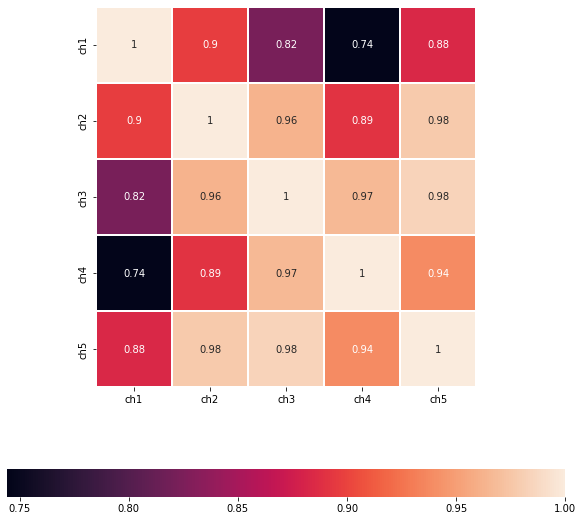

In [31]:
corr = data.corr(method="pearson")
fig, ax = plt.subplots(figsize=(10,10)) 
sns.heatmap(corr, square=True, linewidths=.2, annot=True, cbar_kws={"orientation": "horizontal"})